In [36]:
import torch
import torch.nn as nn
from torch import Tensor
from typing import Tuple
from torchvision.models.resnet import resnet18, resnet34, resnet50

RESNET_FEAT_DIM = {18: 512, 34: 512, 50: 2048}
RESNET_CONV_FEAT_DIM = {18: 256, 34: 256, 50: 1024}
RESNET_TYPE_TO_CLS = {18: resnet18, 34: resnet34, 50: resnet50}

z_dim = 512
emb_dim = 512
hid_dim = 1024
resnet_type = 50

class Reshape(nn.Module):
    def __init__(self, target_shape: Tuple[int]):
        super(Reshape, self).__init__()

        self.target_shape = target_shape

    def forward(self, x):
        return x.view(*self.target_shape)
    

class ConvTransposeBNReLU(nn.Module):
    def __init__(self, num_in_c: int, num_out_c: int, kernel_size: int, *conv_args, **conv_kwargs):
        super(ConvTransposeBNReLU, self).__init__()

        self.block = nn.Sequential(
            nn.ConvTranspose2d(num_in_c, num_out_c, kernel_size, *conv_args, **conv_kwargs),
            nn.BatchNorm2d(num_out_c),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.block(x)


    
class ResNetLastBlock(nn.Module):
    def __init__(self, resnet_type: int, pretrained: bool, should_pool: bool=True):
        super(ResNetLastBlock, self).__init__()

        self.resnet = RESNET_TYPE_TO_CLS[resnet_type](pretrained=pretrained)
        self.should_pool = should_pool

        del self.resnet.conv1
        del self.resnet.bn1
        del self.resnet.relu
        del self.resnet.maxpool
        del self.resnet.layer1
        del self.resnet.layer2
        del self.resnet.layer3
        del self.resnet.fc

    def forward(self, x: Tensor) -> Tensor:
        x = self.resnet.layer4(x)

        if self.should_pool:
            x = self.resnet.avgpool(x)
            x = torch.flatten(x, 1)

        return x

encoder = ResNetLastBlock(50, True, False)
decoder = nn.Sequential(
    ConvTransposeBNReLU(z_dim + emb_dim, hid_dim, 5),
    ConvTransposeBNReLU(hid_dim, hid_dim, 6),
    nn.ConvTranspose2d(hid_dim, RESNET_CONV_FEAT_DIM[resnet_type], 6),
)

decoder(torch.rand(1, z_dim + emb_dim, 14, 14)).shape

torch.Size([1, 1024, 28, 28])

In [19]:
import torch
import torch.nn as nn

class RepeatToSize(nn.Module):
    def __init__(self, target_size: int):
        super(RepeatToSize, self).__init__()
        self.target_size = target_size

    def forward(self, x):
        assert x.ndim == 4

        if self.target_size == 1:
            return x
        else:
            return x.repeat(1, 1, self.target_size, self.target_size)

model = RepeatToSize(3)

model(torch.rand(2, 2, 1, 1))
# sum(p.numel() for p in model.parameters())

tensor([[[[0.7399, 0.7399, 0.7399],
          [0.7399, 0.7399, 0.7399],
          [0.7399, 0.7399, 0.7399]],

         [[0.0919, 0.0919, 0.0919],
          [0.0919, 0.0919, 0.0919],
          [0.0919, 0.0919, 0.0919]]],


        [[[0.5146, 0.5146, 0.5146],
          [0.5146, 0.5146, 0.5146],
          [0.5146, 0.5146, 0.5146]],

         [[0.2894, 0.2894, 0.2894],
          [0.2894, 0.2894, 0.2894],
          [0.2894, 0.2894, 0.2894]]]])

In [30]:
encoder(torch.rand(1, 1024, 28, 28)).shape

torch.Size([1, 2048, 14, 14])

In [1]:
import sys; sys.path.append('..')
import torch
import numpy as np
from firelab.config import Config
from src.models.lat_gm import LatGM
# from src.dataloaders.load_data import load_data
from src.dataloaders.cub import CUB

# config = Config.load('../configs/lat_gm.yml')
# config.all.hp.model.set('pretrained', True)
# config.all.hp.model.set('num_classes', 200)
# config = Config.load('../configs/base.yml')
# ds_train, ds_test, attrs = load_data(Config({
#  'num_reserved_classes': 0,
#  'num_classes': 200,
#  'num_classes_per_task': 20,
#  'dir': '../data/CUB_200_2011',
#  'num_tasks': 10,
#  'name': 'CUB'}), embed_data=True)

In [2]:
import torchvision.transforms as T
from src.dataloaders.cub import CUB

transform = T.Compose([
    T.ToPILImage(),
    T.CenterCrop([448, 448]),
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

ds_train = CUB('../data/CUB_200_2011', train=True, transform=transform)
ds_test = CUB('../data/CUB_200_2011', train=False, transform=transform)

# self.train_dataloader = DataLoader(ds_train, batch_size=self.config.hp.batch_size, shuffle=True)
# self.val_dataloader = DataLoader(ds_test, batch_size=128, shuffle=False)

[Loading dataset]: 100%|██████████| 5794/5794 [02:41<00:00, 35.99it/s]


In [6]:
from src.dataloaders.utils import extract_resnet_features_for_dataset

ds_train_feats = extract_resnet_features_for_dataset(ds_train, resnet_type=50, feat_level='conv', device='cuda', batch_size=256)
ds_test_feats = extract_resnet_features_for_dataset(ds_test, resnet_type=50, feat_level='conv', device='cuda', batch_size=256)

[Extracting features]: 100%|██████████| 23/23 [00:49<00:00,  2.17s/it]


In [7]:
np.save('../data/CUB_EMBEDDED/train_conv_feats_resnet50', ds_train_feats, allow_pickle=True)
np.save('../data/CUB_EMBEDDED/test_conv_feats_resnet50', ds_test_feats, allow_pickle=True)

In [1]:
import numpy as np
data_train = np.load('../data/CUB_EMBEDDED/train_feats_resnet18.npy', allow_pickle=True)
data_test = np.load('../data/CUB_EMBEDDED/test_feats_resnet18.npy', allow_pickle=True)

classes_train = [d[1] for d in data_train]
classes_test = [d[1] for d in data_test]

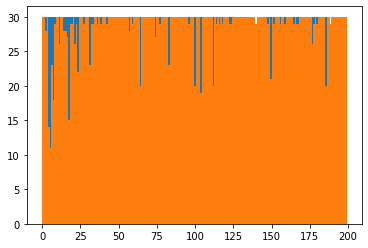

In [16]:
import matplotlib.pyplot as plt

plt.hist(classes_train, bins=200);
plt.hist(classes_test, bins=200);